In [60]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [61]:
torch.__version__

'2.4.0'

In [62]:
device = torch.device("cuda")
device

device(type='cuda')

In [63]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [64]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [65]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [66]:
words[:10]

['had not thought about it until that moment the officers laughter',
 'yes yes assented pierre',
 'he is not to be apprehended by reason but by life said the mason',
 'all looked so at him and flattered by this general admiration he would',
 'hows this colonel he shouted as he approached i told you to fire',
 'but at that instant a tall austrian general in a greatcoat with the',
 'rostov learned later that russian and austrian soldiers had been firing',
 'of delighted amazement',
 'impending battle under a heading which he also read out',
 'success and at the inability of others to understand these things in']

In [67]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [68]:
block_size = 5 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [69]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 5]), torch.int64, torch.Size([204978]), torch.int64)

In [70]:
emb_dim = 64
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[ 2.2041, -0.0132, -1.1518,  ..., -0.5144,  1.1511,  1.8581],
        [-0.1245, -0.9554, -0.8584,  ..., -0.9403, -0.7010, -0.7409],
        [-0.2863,  1.1971,  2.6171,  ..., -0.3117,  0.9981,  0.2052],
        ...,
        [-0.3234,  1.2305,  0.0884,  ...,  1.6741,  1.0375,  0.9949],
        [ 0.2064, -0.0421,  0.2162,  ..., -1.3756, -0.2093,  0.0265],
        [-0.2817,  0.2163, -0.4510,  ..., -0.9082,  0.5316, -0.9277]],
       requires_grad=True)

In [71]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.relu(self.lin1(x))
        x = self.lin2(x)
        return x 
    


In [72]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 1024).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1026 11:54:12.964000 136823610177344 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/64346145.py line 8 
W1026 11:54:12.964000 136823610177344 torch/_dynamo/convert_frame.py:1009] due to: 
W1026 11:54:12.964000 136823610177344 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1026 11:54:12.964000 136823610177344 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1026 11:54:12.964000 136823610177344 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1026 11:54:12.964000 136823610177344 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1026 11:54:12.964000 136823610177344 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1026 11:54:12.964000 136823610177344 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/s

 daniel peasants pere sweetly regretfully attain assuring revived abbe implied helen scherers determines judge richly pop concentrated teacher upstairs outbursts refrain employers dame preliminaries brigade plate undressing platovs accepted mingling conquered romance turns denisovbut important weathercock breathlessly advantageously lap oer loading sinews wallet village stuffy responded knocks ridicule proper reserved remonstrances settled spoke amazed how worthless faint itequality ghost flank rear virile afraidafraid hit tradition aghast refreshing serve emissary pressing replied enthusiasms show mornings azov playacting lagging notre clerk himat mixture actresses delude ridden bring supposed path incessantly eyeglass someday singers pregnant hall greatly depraved virginal musketeers tucked eloquent exhausted
 continued highest thunder due raptures habit cyrils standards acheit simpleminded dispositions shelter copse lises prince wischau tones piquet massacred fill groom solving obey

In [73]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([11189, 64])
_orig_mod.lin1.weight torch.Size([1024, 320])
_orig_mod.lin1.bias torch.Size([1024])
_orig_mod.lin2.weight torch.Size([11189, 1024])
_orig_mod.lin2.bias torch.Size([11189])


In [74]:
len(stoi)

11189

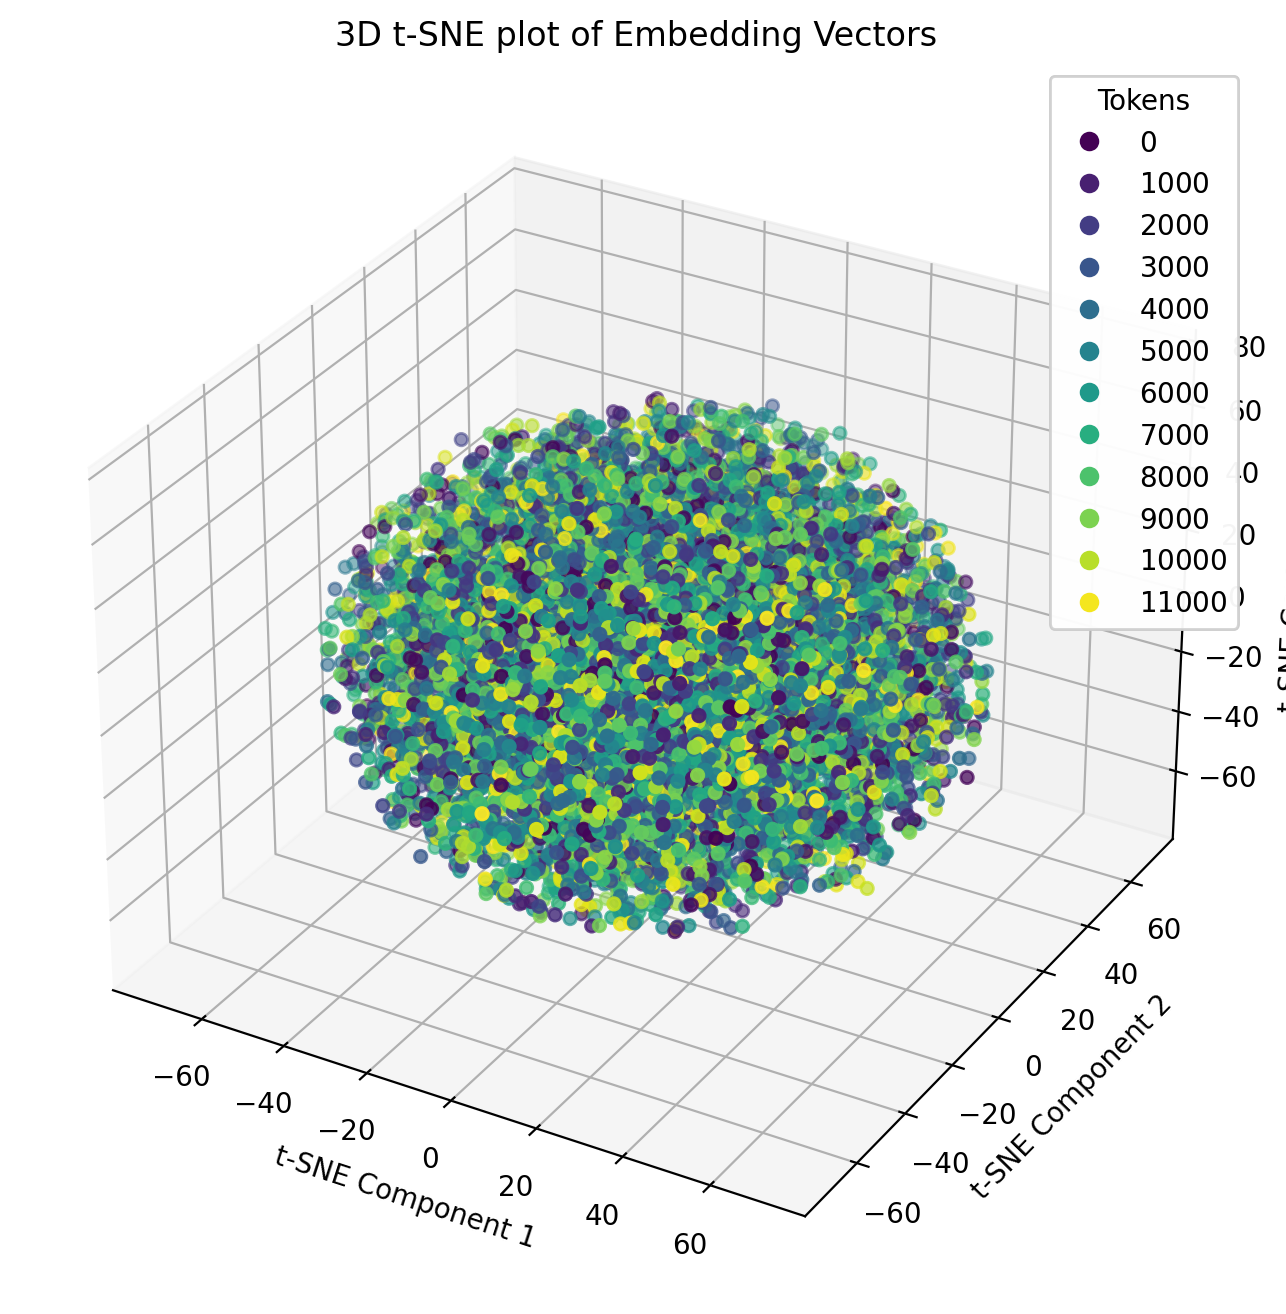

In [75]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [79]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(500):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass


Epoch 0, Loss: 2.7706661224365234
Epoch 10, Loss: 2.677333116531372
Epoch 20, Loss: 2.6556169986724854
Epoch 30, Loss: 2.6364753246307373
Epoch 40, Loss: 2.6185150146484375
Epoch 50, Loss: 2.601212501525879
Epoch 60, Loss: 2.584683895111084
Epoch 70, Loss: 2.5688421726226807
Epoch 80, Loss: 2.553687572479248
Epoch 90, Loss: 2.539140224456787
Epoch 100, Loss: 2.5252041816711426
Epoch 110, Loss: 2.51181697845459
Epoch 120, Loss: 2.4989495277404785
Epoch 130, Loss: 2.4865479469299316
Epoch 140, Loss: 2.474677801132202
Epoch 150, Loss: 2.4631783962249756
Epoch 160, Loss: 2.452110767364502
Epoch 170, Loss: 2.4413769245147705
Epoch 180, Loss: 2.431124687194824
Epoch 190, Loss: 2.4211559295654297
Epoch 200, Loss: 2.4115943908691406
Epoch 210, Loss: 2.4023802280426025
Epoch 220, Loss: 2.393446445465088
Epoch 230, Loss: 2.3848376274108887
Epoch 240, Loss: 2.3764891624450684
Epoch 250, Loss: 2.3684027194976807
Epoch 260, Loss: 2.3606438636779785
Epoch 270, Loss: 2.353084087371826
Epoch 280, Loss

In [80]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 from there was going to the
 face to this project that anatole important gets
 because he has to one of his own looking also was over his spectacles with a
 these words
 prince andrew who was beside him seeing him that
 
 bagrations being were already seen crossing the milldam of the last
 flanks ill on this knoll
 gentlemen all the club members and that he was asked of
 failed till an innovation of happiness or of


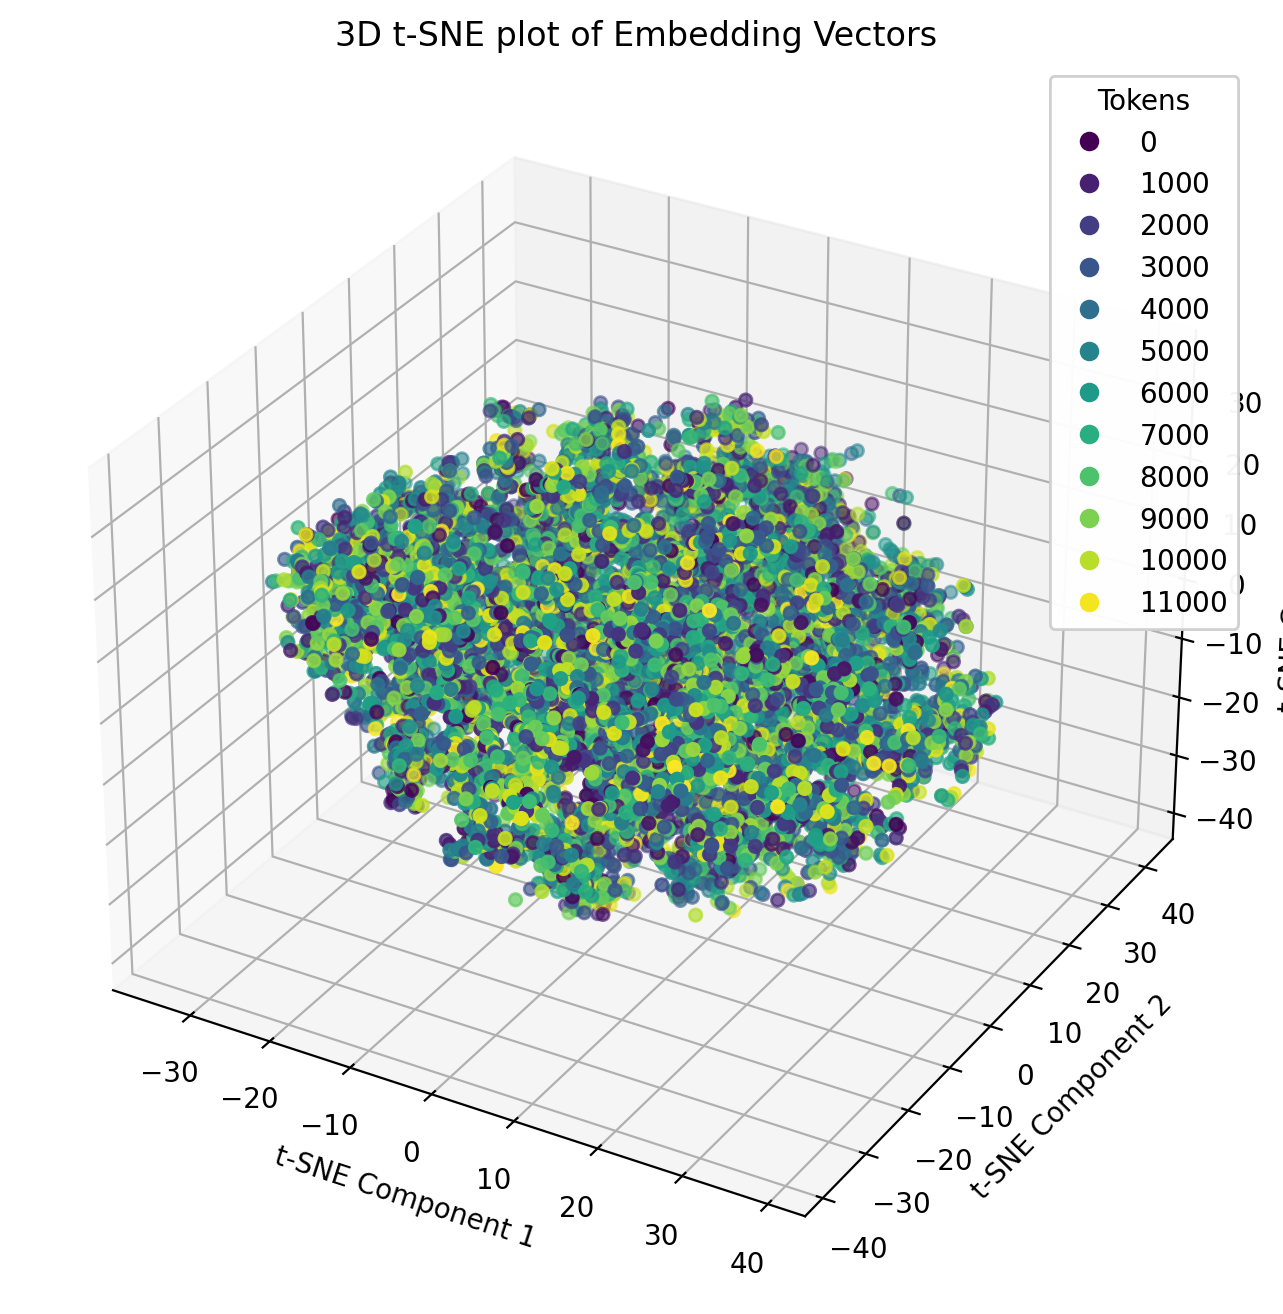

In [82]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [83]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_5_64_1024_r.pth")

In [84]:
model = model.to(device)

In [85]:
pd_itos_i = [i for s,i in stoi.items()]
pd_itos_s = [s for s,i in stoi.items()]

pd_itos = pd.DataFrame({"i":pd_itos_i, "s":pd_itos_s})
pd_stoi = pd.DataFrame({"s":pd_itos_s, "i":pd_itos_i})

pd_itos.to_csv('itos.csv')
pd_stoi.to_csv('stoi.csv')